In [ ]:
import numpy as np
import torch
import trimesh
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

# Configurar o uso da GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_point_cloud(file_path):
    """Carrega uma nuvem de pontos a partir de um arquivo .obj"""
    mesh = trimesh.load(file_path)
    return torch.tensor(mesh.vertices, dtype=torch.float32, device=device)

def nearest_neighbor(src, dst, batch_size=4096, max_distance=1.0):
    """Encontra pontos correspondentes mais próximos com batching na GPU."""
    
    indices_list = []
    src_filtered_list = []
    
    for i in range(0, src.shape[0], batch_size):
        batch = src[i:i+batch_size]  # Pega um lote de pontos de `src`
        
        # Expande as dimensões para broadcasting eficiente na GPU
        batch_exp = batch.unsqueeze(1)  # [batch_size, 1, 3]
        dst_exp = dst.unsqueeze(0)  # [1, M, 3]

        # Calcula a distância euclidiana para os pontos do batch
        distances = torch.norm(batch_exp - dst_exp, dim=2)  # [batch_size, M]
        
        # Encontra os índices dos vizinhos mais próximos
        min_distances, indices = torch.min(distances, dim=1)  # [batch_size]

        # Filtra pontos muito distantes
        mask = min_distances < max_distance
        indices_filtered = indices[mask].to(torch.int64)  # Converte para int64
        src_filtered = batch[mask]

        # Armazena os resultados
        indices_list.append(indices_filtered)
        src_filtered_list.append(src_filtered)

    # Concatenar todos os batches processados
    if indices_list:
        return torch.cat(indices_list), torch.cat(src_filtered_list)
    else:
        return torch.tensor([], dtype=torch.int64, device=device), torch.tensor([], dtype=torch.float32, device=device)

def compute_transformation(A, B):
    """Computa a matriz de rotação R e translação t que alinha A a B."""
    
    # Centróides das nuvens de pontos
    centroid_A = torch.mean(A, axis=0)
    centroid_B = torch.mean(B, axis=0)
    
    # Centraliza as nuvens de pontos
    A_centered = A - centroid_A
    B_centered = B - centroid_B
    
    # Matriz de covariância
    H = torch.matmul(A_centered.T, B_centered)
    
    # Decomposição SVD
    U, S, Vt = torch.linalg.svd(H)
    
    # Cálculo da matriz de rotação
    R = torch.matmul(Vt.T, U.T)

    # Correção caso a matriz de rotação tenha determinante negativo
    if torch.det(R) < 0:
        Vt[-1, :] *= -1
        R = torch.matmul(Vt.T, U.T)

    # Calcula a translação
    t = centroid_B - torch.matmul(R, centroid_A)

    return R, t

def icp(A, B, max_iterations=5, tolerance=1e-6):
    """Executa o algoritmo ICP entre duas nuvens de pontos"""
    src = A.clone()
    prev_error = None
    
    for _ in range(max_iterations):
        indices, src_filtered = nearest_neighbor(src, B)

        if indices.numel() == 0:
            return torch.eye(3, device=device), torch.zeros(3, device=device)

        B_matched = B[indices]

        # Computa a transformação
        R, t = compute_transformation(src_filtered, B_matched)

        # Aplicar a transformação
        src_transformed = (R @ src.T).T + t

        # Calcula a variação da transformação entre iterações
        movement = torch.mean(torch.norm(src_transformed - src, dim=1))

        # Atualiza `src`
        src = src_transformed
        
        # Ajuste para garantir que src e B_matched tenham o mesmo tamanho
        min_size = min(src.shape[0], B_matched.shape[0])
        src = src[:min_size]
        B_matched = B_matched[:min_size]

        # Calcula o erro médio
        mean_error = torch.mean(torch.norm(src - B_matched, dim=1))

        # Critério de parada
        if prev_error is not None and abs(prev_error - mean_error) < tolerance:
            break
        
        prev_error = mean_error
        
        print(f"iteração {_+1}, mean error: {mean_error}")

    return R, t

def apply_transformation(points, R, t):
    """Aplica uma transformação rígida a uma nuvem de pontos"""
    return (R @ points.T).T + t


In [15]:
# Carregar ground-truth
ground_truth = np.load("ground_truth.npy")

# Carregar os scans
num_scans = 30
point_clouds = [load_point_cloud(f"objetos/KITTI-Sequence/{i:06d}/{i:06d}_points.obj") for i in range(num_scans)]

In [ ]:
for i, pc in enumerate(point_clouds[:5]):
    print(f"Scan {i}: {pc.shape}")


In [26]:
# Estimar a trajetória no formato homogêneo (N, 4) diretamente na GPU
trajectory_gpu = torch.zeros((num_scans, 4), dtype=torch.float32, device=device)
trajectory_gpu[:, 3] = 1  # Última coluna como 1 (coordenadas homogêneas)

T = torch.eye(4, dtype=torch.float32, device=device)

for i in range(1, num_scans):
    R, t = icp(point_clouds[i-1], point_clouds[i])
    
    T_new = torch.eye(4, dtype=torch.float32, device=device)
    T_new[:3, :3] = R
    T_new[:3, 3] = T[:3, :3] @ t + T[:3, 3]  # Aplica a translação relativa corretamente

    T[:3, :3] = R @ T[:3, :3]  # Aplica a rotação corretamente
    T[:3, 3] = T_new[:3, 3]  # Atualiza a translação

    trajectory_gpu[i, :3] = T[:3, 3]  # Armazena diretamente na GPU

# **Agora transferimos para CPU e convertemos para NumPy APÓS o loop**
trajectory = trajectory_gpu.cpu().numpy()

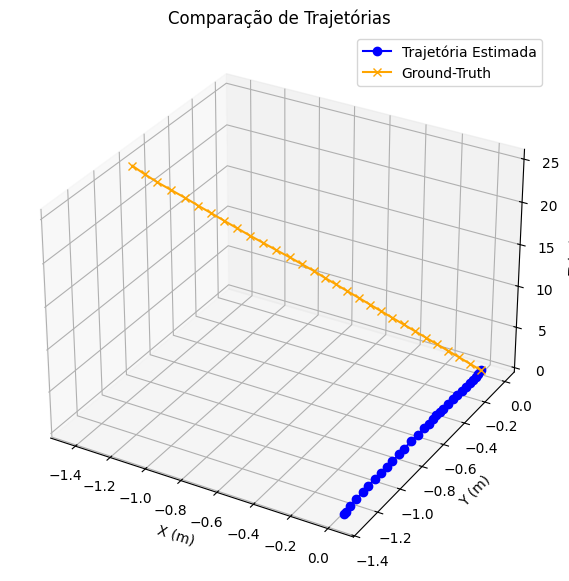

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extrair as coordenadas X, Y, Z da matriz homogênea (última coluna)
gt_x = ground_truth[:, 0, 3]
gt_y = ground_truth[:, 1, 3]
gt_z = ground_truth[:, 2, 3]

# Criar a figura 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot da trajetória estimada
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 
        label='Trajetória Estimada', color='blue', linestyle='-', marker='o')

# Plot da ground-truth
ax.plot(gt_x, gt_y, gt_z, 
        label='Ground-Truth', color='orange', linestyle='-', marker='x')

# Rótulos dos eixos
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Comparação de Trajetórias')

# Adicionar legenda
ax.legend()

# Mostrar o gráfico
plt.show()


In [ ]:
print(ground_truth.shape)
print(trajectory.shape)

(30, 4, 4)
(30, 4)


: 

In [27]:
def compute_trajectory_error(trajectory_est, trajectory_gt):
    """
    Calcula o erro médio da trajetória estimada em relação à ground-truth.
    """
    # Extraímos apenas as coordenadas (X, Y, Z) da ground-truth
    trajectory_gt = trajectory_gt[:, :3, 3]  # Obtém apenas a parte de translação

    # Ajuste de tamanhos caso haja diferenças
    min_size = min(trajectory_est.shape[0], trajectory_gt.shape[0])
    trajectory_est = trajectory_est[:min_size]
    trajectory_gt = trajectory_gt[:min_size]

    # Erro absoluto médio por eixo
    erro_x = np.mean(np.abs(trajectory_est[:, 0] - trajectory_gt[:, 0]))
    erro_y = np.mean(np.abs(trajectory_est[:, 1] - trajectory_gt[:, 1]))
    erro_z = np.mean(np.abs(trajectory_est[:, 2] - trajectory_gt[:, 2]))

    # Erro Euclidiano médio
    erro_medio = np.mean(np.linalg.norm(trajectory_est - trajectory_gt, axis=1))

    return erro_x, erro_y, erro_z, erro_medio

# Carregar ground-truth e calcular erro
trajectory_gt = ground_truth
erro_x, erro_y, erro_z, erro_medio = compute_trajectory_error(trajectory, trajectory_gt)

print(f"Erro médio por eixo: X={erro_x:.4f}, Y={erro_y:.4f}, Z={erro_z:.4f}")
print(f"Erro Euclidiano médio: {erro_medio:.4f}")


ValueError: operands could not be broadcast together with shapes (30,4) (30,3) 